#### [ OBJECT DETECT MODEL - Faster R-CNN ]
- 데이터셋 : cocodataset 
- 카테고리 : 배경, 개, 고양이

[1] 모듈로딩 및 데이터 준비<hr>

In [2]:
## 모듈 로딩
import os

import torch
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


In [3]:
## 데이터 준비
DATA_DIR = '../../data/coco/'

[2] 데이터 전처리 준비<hr>

In [4]:
## 이미지 전처리 관련 인스턴스
## - 이미지 텐서화 및 타입 설정
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

[3] 커스텀 데이터셋 클래스 정의 및 설계<hr>

In [5]:
## -------------------------------------------------------------
## 클래스이름 : COCODataset
## 부모클래스 : Dataset
## -------------------------------------------------------------
class COCODataset(Dataset):
    ## ---------------------------------------------------------
    ## - 필수 오버라이딩 메서드 
    ## ---------------------------------------------------------
    ## ---------------------------------------------------------
    ## 메서드이름: __init__
    ## 매개변수들
    ## ---------------------------------------------------------
    def __init__(self, root, train, transform=None):
        super().__init__()
        
        directory   = "train" if train else "val"
        annotations = os.path.join(root, 
                                   "annotations", 
                                   f"{directory}_annotations.json")
        
        self.coco       = COCO(annotations)
        self.iamge_path = os.path.join(root, directory)
        self.transform  = transform

        self.categories = self._get_categories()
        self.data       = self._load_data()


    ## ---------------------------------------------------------
    ## 메서드이름: __getitem__
    ## 매개변수들: 특정 데이터 인덱스
    ## 반환결과값: 인덱스에 해당하는 이미지와 타겟 반환
    ## ---------------------------------------------------------
    def __getitem__(self, index):
        image, target = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    ## ---------------------------------------------------------
    ## 메서드이름: __len__
    ## 매개변수들: 없음
    ## 반환결과값: 데이터 갯수 반환
    ## ---------------------------------------------------------
    def __len__(self):
        return len(self.data)
    
    ## ---------------------------------------------------------
    ## - 사용자 정의 메서드
    ## ---------------------------------------------------------
    ## ---------------------------------------------------------
    ## 메서드기능: 정수 맵핑 카테고리 반환 내장 메서드 
    ## 메서드이름: _get_categories
    ## 매개변수들: 없음
    ## 반환결과값: 정수 맵핑된 카테고리 Dict
    ## ---------------------------------------------------------
    def _get_categories(self):
        categories = {0: "background"}
        for category in self.coco.cats.values():
            categories[category["id"]] = category["name"]
        return categories
    
    ## ---------------------------------------------------------
    ## 메서드기능: 데이터셋 이미지와 이미지 정보 타겟 반환 내장 메서드 
    ## 메서드이름: _load_data
    ## 매개변수들: 없음
    ## 반환결과값: 이미지데이터와 타겟을 리스트로 담고 있는 리스트 
    ## ---------------------------------------------------------
    def _load_data(self):
        data = []
        for _id in self.coco.imgs:
            ## 이미지 데이터 로딩 
            file_name = self.coco.loadImgs(_id)[0]["file_name"]
            image_path = os.path.join(self.iamge_path, file_name)
            image = Image.open(image_path).convert("RGB")

            ## 이미지 내 객체의 위치와 이미지 클래스 저장 
            boxes, labels = [], []
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            for ann in anns:
                x, y, w, h = ann["bbox"]
                boxes.append([x, y, x + w, y + h])
                labels.append(ann["category_id"])

            ## 이미지의 타겟 정보 즉, 아이디, 박스위치, 클래스 정보
            target = {
                "image_id": torch.LongTensor([_id]),
                "boxes": torch.FloatTensor(boxes),
                "labels": torch.LongTensor(labels)
            }
            data.append([image, target])
        return data

[3] 데이터셋 생성<hr>

In [6]:
## 배치 데이터 생성 함수
## ---------------------------------------------------------
## 함수기능 : 개별 샘플을 미니배치로 결합하는 역할
## 함수이름 : collator
## 매개변수 : 배치크기
## 반환결과 : 배치크기만큼 연결된 데이터
## ---------------------------------------------------------
def collator(batch):
    return tuple(zip(*batch))


In [7]:
## 학습용, 테스트용 데이터셋 생성 
trainDS = COCODataset(DATA_DIR, train=True, transform=transform)
testDS  = COCODataset(DATA_DIR, train=False, transform=transform)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
## 클래스 변환 Dict 생성
IDX_TO_CATEGORY = trainDS.categories
IDX_TO_CATEGORY

{0: 'background', 1: 'cat', 2: 'dog'}

In [ ]:
## 학습용 테스트용 데이터 확인
print(f'[trainDS] 개수 : {len(trainDS)}개 ')
print(f'[testDS] 개수  : {len(testDS)}개 ')

[trainDS] 개수 : 2431개 
[testDS] 개수 : 181개 


In [24]:
## 학습용 데이터셋에서 이미지 1개 
imgTS, targetDict = trainDS[0]   ## <== __getitem__(indx)
print(imgTS.shape, targetDict.keys())

# - 라벨 정보 추출
label = targetDict['labels'].item()

# - 객체 위치 정보 추출 
lx, ly, rx, ry = [round(data.item()) for data in targetDict['boxes'].reshape(-1)]
w , h = rx-lx, ry-ly

print(f'lx, ly, w, h => {lx, ly, w, h}')

torch.Size([3, 479, 640]) dict_keys(['image_id', 'boxes', 'labels'])
lx, ly, w, h => (337, 244, 66, 67)


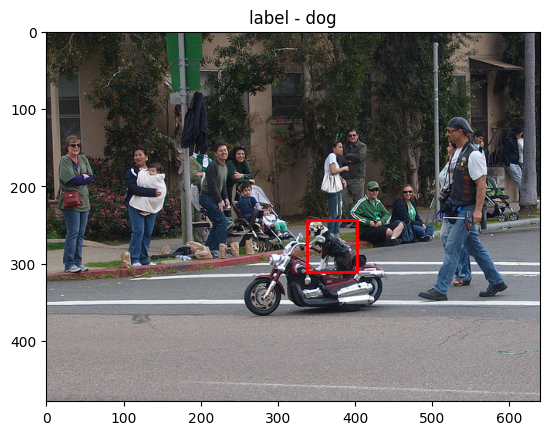

In [ ]:
## 시각화 및 바운딩 박스 
plt.imshow(imgTS.permute(1,2,0))
plt.title(f'label - {IDX_TO_CATEGORY[label]}')

## 바운딩 박스 추가 
ax=plt.gca()   #- get current axis 
ax.add_patch( patches.Rectangle((lx, ly), w, h, color='red', linewidth=2, fill=False) )

plt.show()

[3] 모델 정의 및 설계<hr>
- 모델 네트워크 구성
    * Backbone Network : VGG16
    * Nect Network : RPN 
    * Head Network : Faster R-CNN


In [ ]:
## 모델 관련 모듈 로딩
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.detection import rpn, FasterRCNN
from torchvision import ops

In [ ]:
## --------------------------------------------------------------
## 모델 관련 설정들
## --------------------------------------------------------------

## - Backbone Network 관련
WEIGHTS     = VGG16_Weights.DEFAULT
BACKBONE    = vgg16(weights=WEIGHTS).features
BACKBONE.out_channels = 512

## - Neck Network 관련 
## 앵커 생성자 : 이미지 위에 고정된 크기/비율의 앵커 박스 자동 생성
##             RPN(Region Proposal Network) 입력으로 사용
##            - sizes : 각 피처맵 위치에서 생성할 앵커 박스 기본 크기
##            - aspect_ratios :각 크기별로 만들 앵커 박스 종횡비 (가로:세로 비율)
anchor_generator = rpn.AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

## ROI 생성 인스턴스 : 다단계 피처맵에서 객체 영역(RoI) 추출 후 고정 크기 변환 연산 수행 인스턴스 
##                 - featmap_names : 어떤 피처맵 사용할지 지정 
##                 - output_size   : RoI Align 통해 얻고자 하는 출력 크기. (7, 7) 또는 (14, 14)
##                 - sampling_ratio: RoI 내부에서 서브 픽셀 위치를 샘플링할 때 사용할 포인트 수 
##                                   2는 각 셀당 2×2 지점 샘플링
roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=(7, 7),
    sampling_ratio=2
)


[5] 학습 준비 <hr>

In [ ]:
## 학습관련 설정 값 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
TBATCH_SIZE = 4
VBATCH_SIZE = 1



In [82]:
## 데이터셋 관련 인스턴스 생성 
TRAIN_DL = DataLoader( trainDS, batch_size=TBATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collator)
TEST_DL  = DataLoader( testDS,  batch_size=VBATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collator )

In [ ]:

## 인스턴스 생성 
MODEL = FasterRCNN( backbone=BACKBONE,
                    num_classes=3,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler
                    ).to(DEVICE)



In [ ]:
from torch import optim


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
for epoch in range(5):
    cost = 0.0
    for idx, (images, targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost += losses

    lr_scheduler.step()
    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

In [ ]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image


def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )
 
threshold = 0.5
categories = testDS.categories
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)
        
        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()
        
        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))

        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")
            
        plt.show()

In [ ]:
import numpy as np
from pycocotools.cocoeval import COCOeval


with torch.no_grad():
    model.eval()
    coco_detections = []
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = np.array(
                    [
                        image_id,
                        box[0],
                        box[1],
                        box[2],
                        box[3],
                        float(scores[instance_id]),
                        int(labels[instance_id]),
                    ]
                )
                coco_detections.append(prediction)

    coco_detections = np.asarray(coco_detections)
    coco_gt = test_dataloader.dataset.coco
    coco_dt = coco_gt.loadRes(coco_detections)
    coco_evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()